#Import Model and Download Dataset

In [22]:
#rahul sharma
#https://colab.research.google.com/drive/1ldnii3sGJaUHPV6TWImykbeE_O-8VIIN#scrollTo=VBYDQI_we0vA
#https://www.curiousily.com/posts/object-detection-on-custom-dataset-with-tensorflow-2-and-keras-using-python/
#https://www.youtube.com/watch?v=LDQ0C8WwzHY
from google.colab import drive
drive.mount('/content/drive')
import os
os.getcwd()
os.chdir('/content/drive/My Drive/yolo/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!nvidia-smi

Mon Feb 17 06:04:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [24]:
!git clone https://github.com/fizyr/keras-retinanet.git

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


In [25]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [26]:
%cd keras-retinanet/
!pip install .

/content/drive/My Drive/yolo/keras-retinanet
Processing /content/drive/My Drive/yolo/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170187 sha256=452782812aebc3b0a3830c6fa9370368a35f2b9f63f7789d5430fae047e66be3
  Stored in directory: /root/.cache/pip/wheels/d6/41/3f/70a9fd688810d8f9072ebc8191cbf37ea605d39ba25a8585e3
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 0.5.1
    Uninstalling keras-retinanet-0.5.1:
      Successfully uninstalled keras-retinanet-0.5.1


In [27]:
!python setup.py build_ext --inplace #create c extension

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [28]:
!pip install gdown
!pip install tensorflow-gpu

In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [30]:
!gdown --id 1mTtB8GTWs74Yeqm0KMExGJZh1eDbzUlT --output indian_number_plates.json #download json file

Downloading...
From: https://drive.google.com/uc?id=1mTtB8GTWs74Yeqm0KMExGJZh1eDbzUlT
To: /content/drive/My Drive/yolo/keras-retinanet/indian_number_plates.json
100% 92.5k/92.5k [00:00<00:00, 28.5MB/s]


In [0]:
os.makedirs("snapshots", exist_ok=True) #create directory and download pretrain mode RetinaNet

In [32]:
!gdown --id 1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R --output snapshots/resnet50_csv_10.h5

Downloading...
From: https://drive.google.com/uc?id=1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R
To: /content/drive/My Drive/yolo/keras-retinanet/snapshots/resnet50_csv_10.h5
249MB [00:03, 69.5MB/s]


In [0]:
plates_df = pd.read_json('indian_number_plates.json', lines=True)

In [34]:
plates_df.head(2)

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [0]:
os.makedirs("number_plates", exist_ok=True)

In [36]:
dataset = dict()
dataset["image_name"] = list()
dataset["x_min"] = list()
dataset["y_min"] = list()
dataset["x_max"] = list()
dataset["y_max"] = list()
dataset["class_name"] = list()

counter = 0
for index, row in plates_df.iterrows():
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')
    img.save(f'number_plates/licensed_car_{counter}.jpeg', "JPEG")
    
    dataset["image_name"].append(f'number_plates/licensed_car_{counter}.jpeg')
    
    data = row["annotation"]
  
    width = data[0]["imageWidth"]
    height = data[0]["imageHeight"]

    dataset["x_min"].append(int(round(data[0]["points"][0]["x"] * width)))
    dataset["y_min"].append(int(round(data[0]["points"][0]["y"] * height)))
    dataset["x_max"].append(int(round(data[0]["points"][1]["x"] * width)))
    dataset["y_max"].append(int(round(data[0]["points"][1]["y"] * height)))
    dataset["class_name"].append("license_plate")
    
    counter += 1
print("Downloaded {} car images.".format(counter))

Downloaded 237 car images.


In [37]:
df = pd.DataFrame(dataset)
df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
0,number_plates/licensed_car_0.jpeg,582,274,700,321,license_plate
1,number_plates/licensed_car_1.jpeg,80,382,288,449,license_plate
2,number_plates/licensed_car_2.jpeg,41,219,115,260,license_plate
3,number_plates/licensed_car_3.jpeg,217,313,359,359,license_plate
4,number_plates/licensed_car_4.jpeg,209,220,866,554,license_plate


In [0]:
def show_image_objects(image_row):

  img_path = image_row.image_name
  box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]

  image = read_image_bgr(img_path)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_box(draw, box, color=(255, 255, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

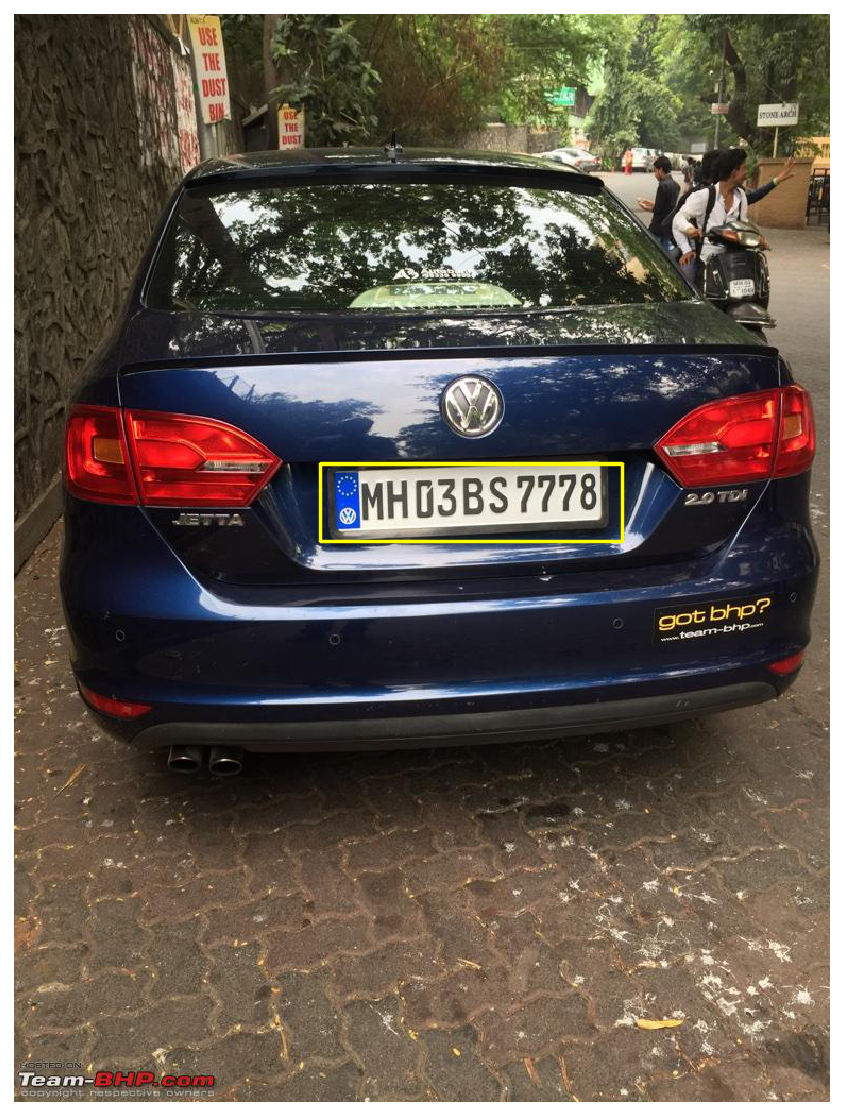

In [39]:
show_image_objects(df.iloc[23])

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 6 columns):
image_name    237 non-null object
x_min         237 non-null int64
y_min         237 non-null int64
x_max         237 non-null int64
y_max         237 non-null int64
class_name    237 non-null object
dtypes: int64(4), object(2)
memory usage: 11.2+ KB


#Preprocessing

In [0]:
#split data from training and testing

train_df,test_df=train_test_split(df,test_size=0.2,random_state=RANDOM_SEED) #RANDOM_SEED is a number that not change split data position every times same

In [66]:
train_df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
183,number_plates/licensed_car_183.jpeg,169,260,358,298,license_plate
201,number_plates/licensed_car_201.jpeg,251,187,375,234,license_plate
230,number_plates/licensed_car_230.jpeg,140,149,324,220,license_plate
95,number_plates/licensed_car_95.jpeg,302,420,671,534,license_plate
190,number_plates/licensed_car_190.jpeg,115,86,227,117,license_plate


In [67]:
test_df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
115,number_plates/licensed_car_115.jpeg,48,74,599,188,license_plate
15,number_plates/licensed_car_15.jpeg,274,344,517,431,license_plate
211,number_plates/licensed_car_211.jpeg,157,89,382,160,license_plate
126,number_plates/licensed_car_126.jpeg,443,255,639,347,license_plate
6,number_plates/licensed_car_6.jpeg,227,241,444,315,license_plate
